# __Model Visualisation__

### __Deep Learning__

#### __Project: Image Captioning with Visual Attention__

In [1]:
import os
os.chdir(os.environ["PYTHONPATH"])

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import scripts.data_loading as dl
import scripts.data_processing as dp
import scripts.data_visualization as dv
import scripts.model as model

%load_ext autoreload
%autoreload 2

### Word Embeddings layer Visualisation

In [2]:
DECODER_PATH = "./models/best_models/best_model_e128_a256_d512_lr0.0003-extended_with_loss.pth"

In [3]:
def load_decoder(state_path: str) -> model.LSTMDecoder:
    decoder_state = torch.load(state_path, map_location=torch.device("cpu"))["decoder"]

    num_embeddings = decoder_state["word_embedding.weight"].shape[0]
    embedding_dim = decoder_state["word_embedding.weight"].shape[1]
    encoder_dim = 196
    attention_dim = decoder_state["attention.W_1.weight"].shape[0]
    decoder_dim = decoder_state["init_c.weight"].shape[0]

    decoder = model.LSTMDecoder(
        num_embeddings, embedding_dim, encoder_dim, decoder_dim, attention_dim
    )
    decoder.load_state_dict(decoder_state)

    return decoder

In [4]:
decoder = load_decoder(DECODER_PATH)
embeddings = decoder.word_embedding.weight.detach().numpy()

E_reduced = dv.reduce_to_k_dim(embeddings)

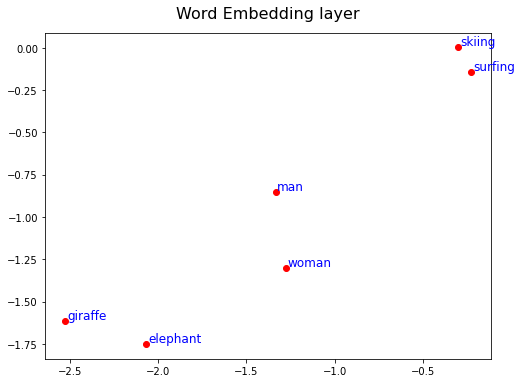

In [5]:
plt.rcParams["figure.figsize"] = (8, 6)

plt.title("Word Embedding layer", fontsize=16, y=1.025)
dv.plot_embeddings(E_reduced, ["elephant", "giraffe", "woman", "man", "surfing", "skiing"])

In [6]:
del decoder, embeddings, E_reduced

### Attention Context Visualisation

In [7]:
MODEL_PATH = "./models/checkpoints/decoder_lr_3e-04_dropout_0.5_lambda_0.0.pth"
state_dict = torch.load(MODEL_PATH)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

decoder = model.LSTMDecoder(num_embeddings=10_004, embedding_dim=128, encoder_dim=196, decoder_dim=512, attention_dim=256)
decoder.load_state_dict(state_dict["decoder"])
decoder.to(device)

encoder = model.VGG19Encoder()
encoder.to(device)

print("Loading FINISHED")

Loading FINISHED


In [8]:
root = dl.DATASET_PATHS[dl.DatasetType.VALIDATION].images
ann_json = dl.DATASET_PATHS[dl.DatasetType.VALIDATION].captions_json

coco = torchvision.datasets.CocoCaptions(root, ann_json)
coco_preprocessed_img = torchvision.datasets.CocoCaptions(root, ann_json, dp.VGGNET_PREPROCESSING_PIPELINE)
vocabulary = dp.Vocabulary()

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


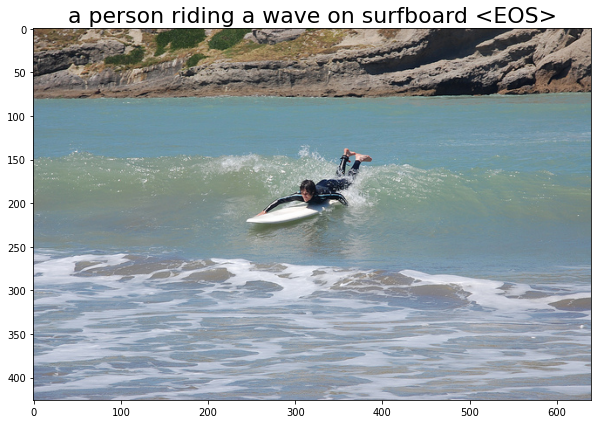

In [9]:
image, _ = coco[555]
img, _ = coco_preprocessed_img[555]

img = img.to(device)
feature_maps, feature_mean = encoder.forward(img.unsqueeze(0))

sequence, contexts, betas = decoder.greedy_decoding(
    feature_maps=feature_maps,
    feature_mean=feature_mean,
    start_token_index=vocabulary.word2idx("<SOS>"),
    end_token_index=vocabulary.word2idx("<EOS>"),
    max_length=100
)

sequence = dp.TextPipeline.decode_caption(vocabulary, sequence)
sequence = sequence + ' <EOS>'  

plt.rcParams["figure.figsize"] = (10, 10)
plt.title(sequence, fontsize=22)
plt.imshow(image)

In [10]:
plt.rcParams["figure.figsize"] = (5, 5)

image = np.array(image)
sequence = sequence.split()

In [11]:
def plot_context(word_index):
    context = contexts[word_index].cpu().detach().view(14, 14).numpy()
    context_map = dv.paint_attention(image, (224, 224), context, betas[word_index])

    plt.title(sequence[word_index], fontsize=20)
    plt.axis("off")
    plt.imshow(context_map)

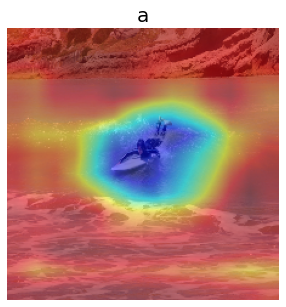

In [12]:
plot_context(0)

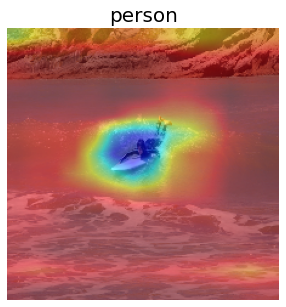

In [13]:
plot_context(1)

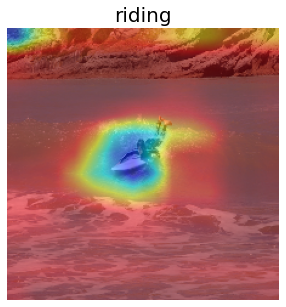

In [14]:
plot_context(2)

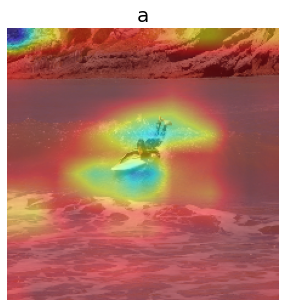

In [15]:
plot_context(3)

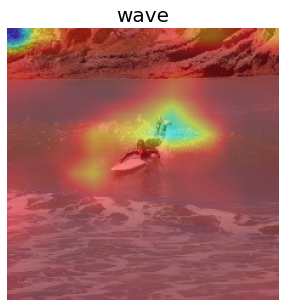

In [16]:
plot_context(4)

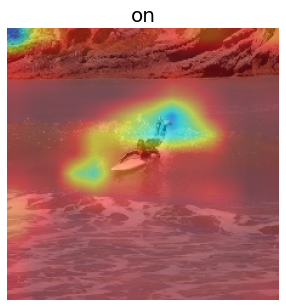

In [17]:
plot_context(5)

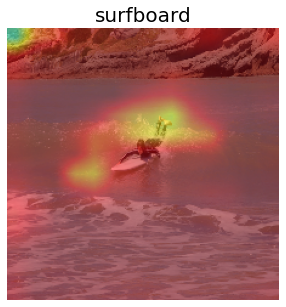

In [18]:
plot_context(6)

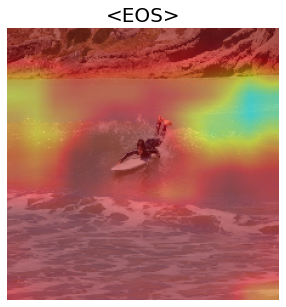

In [19]:
plot_context(7)

### Beta coefficients

In [20]:
sequence

['a', 'person', 'riding', 'a', 'wave', 'on', 'surfboard', '<EOS>']

In [21]:
betas

[0.9986680746078491,
 0.9915851354598999,
 0.9481526613235474,
 0.9596864581108093,
 0.894698977470398,
 0.7917904257774353,
 0.5777886509895325,
 0.602938175201416]

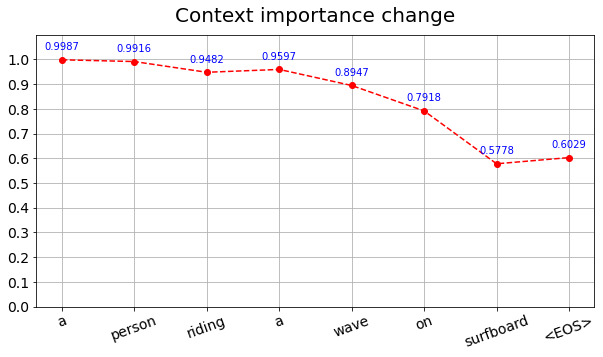

In [22]:
plt.rcParams["figure.figsize"] = (10, 5)

plt.title("Context importance change", fontsize=20, y=1.025)
plt.tick_params(labelsize=14)
plt.grid("on")
dv.plot_betas(betas, sequence)